In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16, EfficientNetB0

In [ ]:
base_dir = '/content/drive/MyDrive/Guava dataset'  # <-- Update this if needed
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

img_size = (224, 224)
batch_size = 32
epochs = 10

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)

train_data = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=True)
val_data = datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test_data = datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

class_names = list(train_data.class_indices.keys())
num_classes = len(class_names)


Found 2647 images belonging to 3 classes.
Found 755 images belonging to 3 classes.
Found 382 images belonging to 3 classes.


In [ ]:
# === Model 1: Simple CNN ===
def build_simple_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2), #Reduce the size of data,learn conplex pattern,learning/hidden lyar
        Conv2D(64, (3, 3), activation='relu'), #64 filters
        MaxPooling2D(2, 2),
        Flatten(),#2dto1d
        Dense(128, activation='relu'), #ads neoron
        Dropout(0.5), #speed breaking
        Dense(num_classes, activation='softmax') #final prediction,output lay,multiclass
    ])
    return model

# === Model 2: VGG16 Transfer Learning ===
def build_vgg16_model():
    base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base.trainable = False
    model = Sequential([
        base,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# === Model 3: EfficientNetB0 ===
def build_efficientnet():
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base.trainable = False
    model = Sequential([
        base,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
def train_and_evaluate(model, name):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"\n🚀 Training {name}...")
    history = model.fit(train_data, validation_data=val_data, epochs=epochs)

    # --- Plot accuracy and loss ---
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title(f'{name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title(f'{name} Loss')
    plt.legend()
    plt.show()

    # --- Confusion Matrix (Validation) ---
    val_data.reset()
    preds = model.predict(val_data)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_data.classes
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{name} - Validation Confusion Matrix')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

    print(f"\n📋 Validation Classification Report for {name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # --- Test Evaluation ---
    print(f"\n🧪 Final Test Evaluation for {name}...")
    test_data.reset()
    test_preds = model.predict(test_data)
    test_y_pred = np.argmax(test_preds, axis=1)
    test_y_true = test_data.classes

    test_cm = confusion_matrix(test_y_true, test_y_pred)
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{name} - Test Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print(f"\n📋 Test Classification Report for {name}:\n")
    print(classification_report(test_y_true, test_y_pred, target_names=class_names))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🚀 Training Simple CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1259s 15s/step - accuracy: 0.4760 - loss: 2.8699 - val_accuracy: 0.8755 - val_loss: 0.3403
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 330s 4s/step - accuracy: 0.8678 - loss: 0.3708 - val_accuracy: 0.9099 - val_loss: 0.2390
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy: 0.9162 - loss: 0.2454 - val_accuracy: 0.9377 - val_loss: 0.1781
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 304s 4s/step - accuracy: 0.9367 - loss: 0.1853 - val_accuracy: 0.9232 - val_loss: 0.2003
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 294s 4s/step - accuracy: 0.9584 - loss: 0.1270 - val_accuracy: 0.9430 - val_loss: 0.1680
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 308s 4s/step - accuracy: 0.9702 - loss: 0.0875 - val_accuracy: 0.9510 - val_loss: 0.1534
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 312s 4s/step - accuracy: 0.9655 - loss: 0.1050 - val_accuracy: 0.9523 - val_loss: 0.1635
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 304s 4s/step - accuracy: 0.9866 - loss: 0.0472 - val_accuracy: 0.9404 -

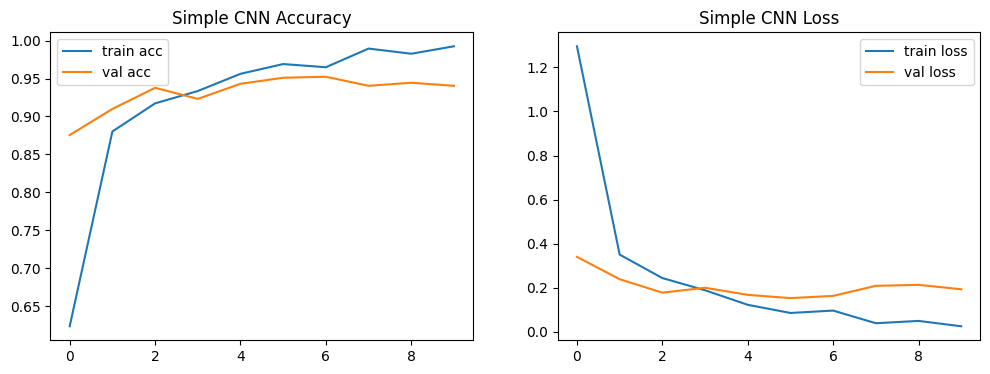

24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


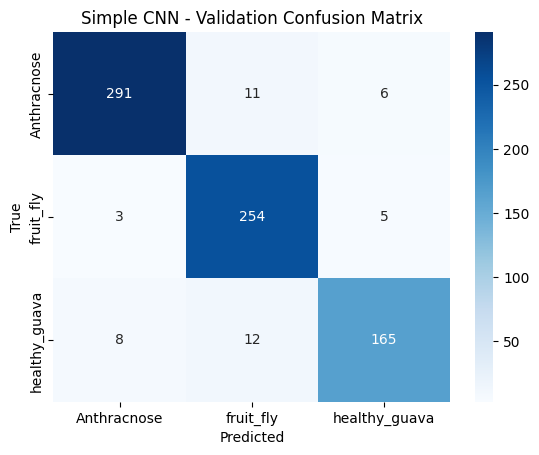


📋 Validation Classification Report for Simple CNN:

               precision    recall  f1-score   support

  Anthracnose       0.96      0.94      0.95       308
    fruit_fly       0.92      0.97      0.94       262
healthy_guava       0.94      0.89      0.91       185

     accuracy                           0.94       755
    macro avg       0.94      0.94      0.94       755
 weighted avg       0.94      0.94      0.94       755


🧪 Final Test Evaluation for Simple CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 120s 11s/step


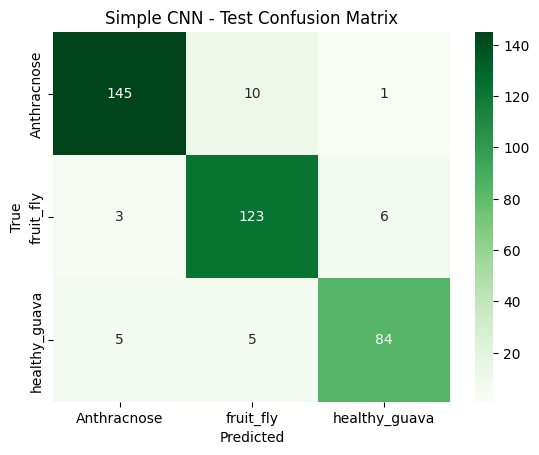


📋 Test Classification Report for Simple CNN:

               precision    recall  f1-score   support

  Anthracnose       0.95      0.93      0.94       156
    fruit_fly       0.89      0.93      0.91       132
healthy_guava       0.92      0.89      0.91        94

     accuracy                           0.92       382
    macro avg       0.92      0.92      0.92       382
 weighted avg       0.92      0.92      0.92       382

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🚀 Training VGG16...
Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2134s 26s/step - accuracy: 0.6940 - loss: 1.4561 - val_accuracy: 0.9709 - val_loss: 0.1133
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2112s 26s/step - accuracy: 0.9500 - loss: 0.1530 - val_accuracy: 0.9219 - val_loss: 0.1750
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2119s 26s/step - accuracy: 0.9600 - loss: 0.0965 - val_accuracy: 0.9815 - val_loss: 0.0608
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2157s 26s/step - accuracy: 0.9762 - loss: 0.0694 - val_accuracy: 0.9

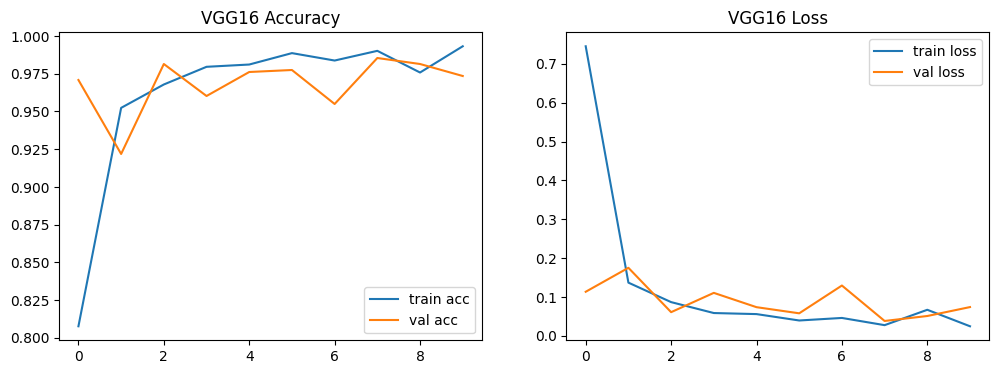

24/24 ━━━━━━━━━━━━━━━━━━━━ 467s 19s/step


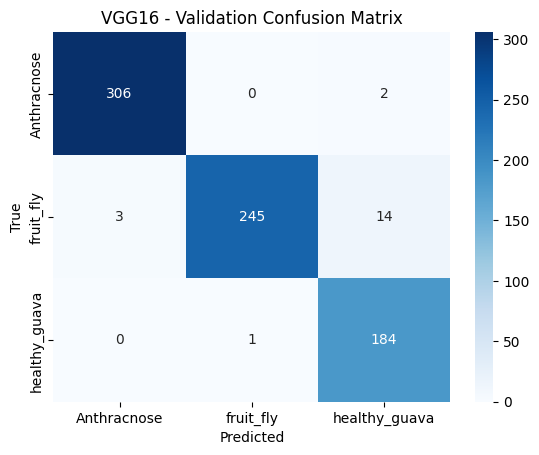


📋 Validation Classification Report for VGG16:

               precision    recall  f1-score   support

  Anthracnose       0.99      0.99      0.99       308
    fruit_fly       1.00      0.94      0.96       262
healthy_guava       0.92      0.99      0.96       185

     accuracy                           0.97       755
    macro avg       0.97      0.97      0.97       755
 weighted avg       0.98      0.97      0.97       755


🧪 Final Test Evaluation for VGG16...
12/12 ━━━━━━━━━━━━━━━━━━━━ 242s 20s/step


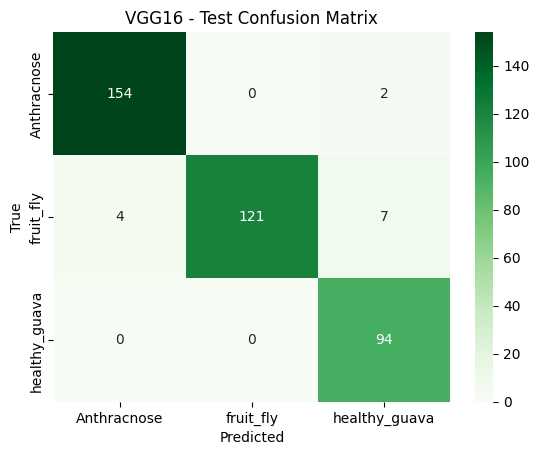


📋 Test Classification Report for VGG16:

               precision    recall  f1-score   support

  Anthracnose       0.97      0.99      0.98       156
    fruit_fly       1.00      0.92      0.96       132
healthy_guava       0.91      1.00      0.95        94

     accuracy                           0.97       382
    macro avg       0.96      0.97      0.96       382
 weighted avg       0.97      0.97      0.97       382

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🚀 Training EfficientNetB0...
Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 312s 4s/step - accuracy: 0.3180 - loss: 3.2470 - val_accuracy: 0.4079 - val_loss: 1.0944
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 326s 4s/step - accuracy: 0.3961 - loss: 1.1046 - val_accuracy: 0.4079 - val_loss: 1.0886
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 294s 4s/step - accuracy: 0.4072 - loss: 1.0874 - val_accuracy: 0.4079 - val_loss: 1.0848
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 305s 4s/step - accuracy: 0.3917 - loss: 1.0861 - val_accuracy: 0.4079 

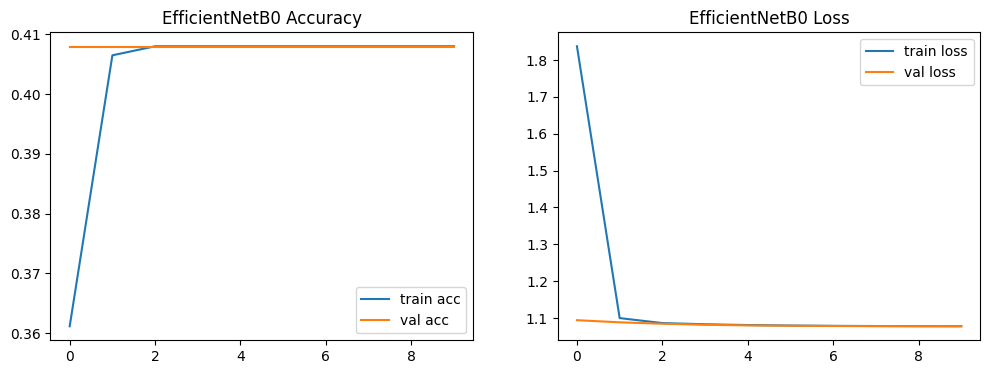

24/24 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step


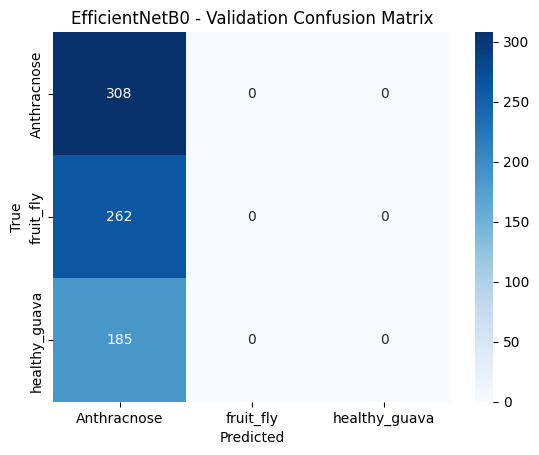


📋 Validation Classification Report for EfficientNetB0:

               precision    recall  f1-score   support

  Anthracnose       0.41      1.00      0.58       308
    fruit_fly       0.00      0.00      0.00       262
healthy_guava       0.00      0.00      0.00       185

     accuracy                           0.41       755
    macro avg       0.14      0.33      0.19       755
 weighted avg       0.17      0.41      0.24       755


🧪 Final Test Evaluation for EfficientNetB0...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step


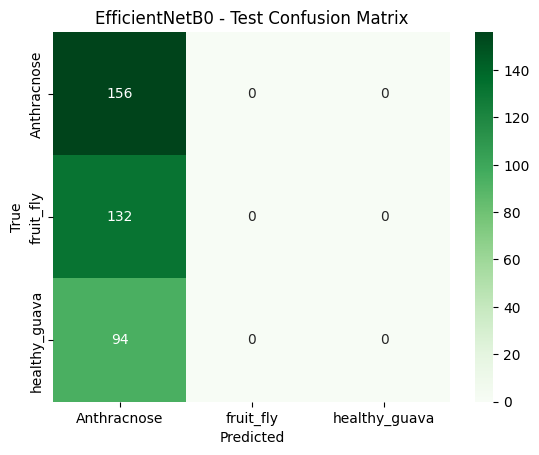


📋 Test Classification Report for EfficientNetB0:

               precision    recall  f1-score   support

  Anthracnose       0.41      1.00      0.58       156
    fruit_fly       0.00      0.00      0.00       132
healthy_guava       0.00      0.00      0.00        94

     accuracy                           0.41       382
    macro avg       0.14      0.33      0.19       382
 weighted avg       0.17      0.41      0.24       382



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# === Run All Models ===
train_and_evaluate(build_simple_cnn(), "Simple CNN")
train_and_evaluate(build_vgg16_model(), "VGG16")
train_and_evaluate(build_efficientnet(), "EfficientNetB0")